In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import logistic
from scipy.optimize import basinhopping
from IPython.display import clear_output, Javascript, Markdown
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import scipy.io
import gc
import datetime
import time
import random
import matplotlib
import nbimporter
from _create_pdf import create_spins;
from _helper_functions import tsallis, cauchy, find_nearest, odeintz, find_nearest_sorted_left
from _steady_state import a_steady
from _mbes import mbes, mbes_soc
from _do_calculation import solve_mbes
#matplotlib.pyplot.switch_backend('nbAgg')
#%qtconsole

Importing Jupyter notebook from _create_pdf.ipynb
Importing Jupyter notebook from _helper_functions.ipynb
Importing Jupyter notebook from _steady_state.ipynb
Importing Jupyter notebook from _mbes.ipynb
Importing Jupyter notebook from _do_calculation.ipynb


In [2]:
gcoll = 1.16160992e+01
q = 2.25646283e+00
quali = 1416
fr = 3.2981e3;
kappa = np.pi*fr/quali #HWHM
delta = 0*2*np.pi #detuning cavity to spin central frequency ws-wc
deltac = 0*2*np.pi #detuning drive to cavity wc-wp
gperp = 2*np.pi*0.09 #HWHM
gpar = 2*np.pi*.001#0.001 #HWHM
gammaq = 12.5226307
nbins = 701#701#5000#20
#g0 = gcoll/sqrt(nspins)
print(kappa)

7.317292888986227


In [3]:
def pulse_rwa(t, args):
    wgrund = args[0]
    fcomps = args[1]
    offset = args[2]
    pulse = 0
    for i in range(len(fcomps)):
        pulse = pulse+(fcomps[i])*np.sin((i+1)*wgrund*t)
    pulse += offset
    tend = np.pi/wgrund
    pulse *= logistic.cdf(t, loc=0.01, scale=.002)*(1-logistic.cdf(t, loc=tend-0.01, scale=.002))
    return pulse

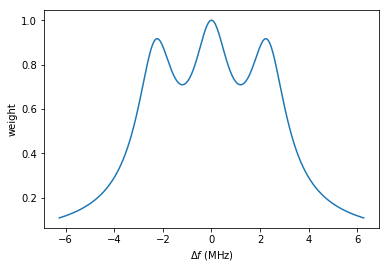

In [4]:
spins, gs, pdf = create_spins(gcoll, q, delta, gammaq, nbins, holes=False, inhomo=True, hyperfine=True)

plt.figure()
plt.plot(spins, pdf/max(pdf))
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('weight');
#%qtconsole

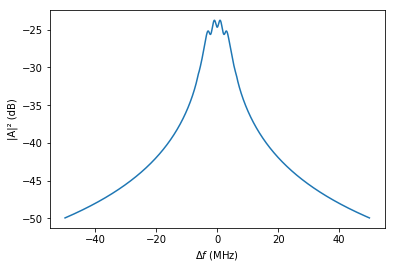

In [5]:
initsteady = (0.1,0.1)
fstart = 50
deltaarr = np.linspace(-fstart*2*np.pi,fstart*2*np.pi, 2000)
etasteady = 0.00001
losasteady = np.zeros(np.shape(deltaarr))
losareal = np.zeros(np.shape(deltaarr))
losaimag = np.zeros(np.shape(deltaarr))

newinit = initsteady
for i, delt in enumerate(deltaarr):
    ar, ai = a_steady(etasteady, delt, gs, spins, gpar, gperp, kappa, newinit)
    newinit = (ar, ai)
    losasteady[i] = ai**2+ar**2
    losareal[i] = ar
    losaimag[i] = ai

fig = plt.figure()
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('|A|² (dB)');
plt.plot(deltaarr/2/np.pi, 10*np.log10(losasteady/0.0000000001))
#deltaarr[find(losasteady == max(losasteady))]/2/pi

# SOC pulses

In [6]:
pumptime = 200e-3#5*np.pi/gcoll
decaytime = 500e-3
dt = 4e-3 #The time resolution of the AWG. Don't change that because the solution of the MBEs are written in a way that use that as time resolution
numsteps = int(pumptime/dt)
tlist = np.arange(0,pumptime+dt,dt)
tlistdecay = np.arange(0, decaytime+dt, dt)

# test time it takes to calculate


init = np.ones(nbins*2+1)*(-1)
init[0] = 0
init[1::2] = 0

### Calibrate power

In [7]:
pulsei = np.ones((len(tlist)))

pin = np.arange(-20, 0,0.1)
aref = 500

alos = np.zeros((len(pin), len(tlist)+len(tlistdecay)))
szlos = np.zeros(np.shape(alos))
szall = np.zeros((len(pin), len(tlist)+len(tlistdecay), nbins))
small = np.zeros(np.shape(szall))
smlos = np.zeros(np.shape(alos))

for ctr, p in enumerate(pin):
    dr = aref*10**(p/20.)
    asolpump, asoldecay, infodict = solve_mbes(mbes, init, pdf, tlist, tlistdecay, dr, kappa, deltac, gs, gperp, spins, gpar)
    alos[ctr, : ] = np.hstack((abs(asolpump[:,0])**2, abs(asoldecay[:,0])**2))
    szlos[ctr, :] = np.hstack((np.real(np.sum(asolpump[:, 2::2], axis=1)), np.real(np.sum(asoldecay[:, 2::2], axis=1))))
    szall[ctr, :, :] = np.vstack((np.real(asolpump[:,2::2]), np.real(asoldecay[:,2::2])))
    small[ctr, :, :] = np.vstack((np.real(asolpump[:,1::2]), np.real(asoldecay[:,1::2])))
    smlos[ctr, :] = np.hstack((np.real(np.sum(asolpump[:, 1::2], axis=1)), np.real(np.sum(asoldecay[:, 1::2], axis=1))))

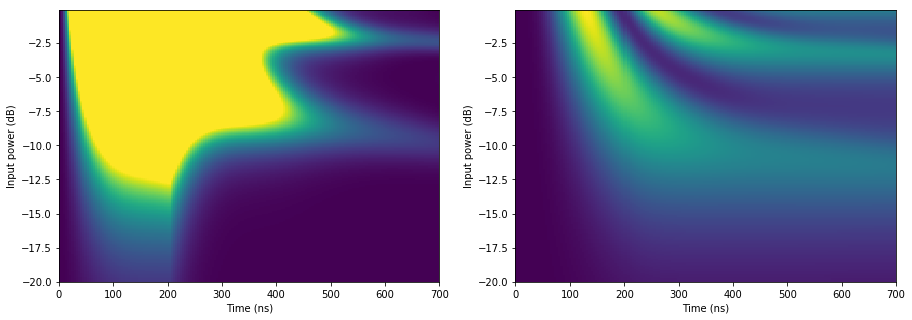

In [8]:
tplot = np.linspace(0, 1000*(pumptime+decaytime), len(tlist)+len(tlistdecay))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.pcolor(tplot, pin, alos, vmin=0, vmax=60)
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Input power (dB)');

ax2.pcolor(tplot, pin, szlos)
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Input power (dB)');

### Linear Rabi oscillations

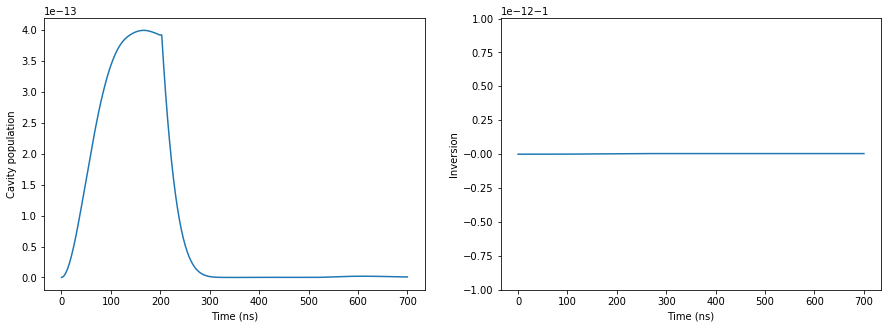

In [9]:
alos = np.zeros((len(tlist)+len(tlistdecay)))
szlos = np.zeros(np.shape(alos))

asolpump, asoldecay, infodict = solve_mbes(mbes, init, pdf, tlist, tlistdecay, 0.00001, kappa, deltac, gs, gperp, spins, gpar)
alos = np.hstack((abs(asolpump[:,0])**2, abs(asoldecay[:,0])**2))
szlos = np.hstack((np.real(np.sum(asolpump[:, 2::2], axis=1)), np.real(np.sum(asoldecay[:, 2::2], axis=1))))
                  
                  
tplot = np.linspace(0, 1000*(pumptime+decaytime), len(tlist)+len(tlistdecay))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(tplot, alos)
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Cavity population');

ax2.plot(tplot, szlos)
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Inversion');

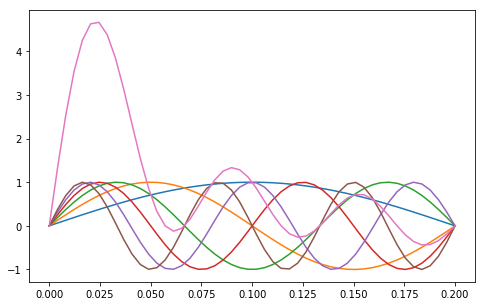

In [10]:
number_fcp = 6
ttest = np.linspace(0,pumptime,numsteps)
wgrund = np.pi/ttest[-1]
sumsin = np.zeros((number_fcp, len(ttest)))

fig, ax = plt.subplots(1,1, figsize=(8,5))

for i in range(number_fcp):
    sumsin[i, :] = np.sin(wgrund*ttest*(i+1))
    ax.plot(ttest, sumsin[i,:])
ax.plot(ttest, np.sum(sumsin, axis=0))
maxfourier = max(np.sum(sumsin, axis=0))

In [11]:
class BasinHopping:
    
    def __init__(self):
        self.tp = np.arange(0,pumptime+dt,dt)
        self.td = np.arange(0, decaytime+dt, dt)
        self.number_fcp = number_fcp
        self.max_ampl = aref/maxfourier
        self.max_t_ampl = aref
        self.target_time_decay = np.pi/gcoll/2 #when after switching off the pulse the inversion should be maximum
        self.wgrund = np.pi/self.tp[-1]
        self.plot_handle = None
        self.counter = 0
        self.solution = None
        self.fcomps = None
        self.idx = -1
        self.fitness = 0
        self.vars = []
        self.fig = None
        self.disp1 = display(Markdown(""), display_id='0')
        self.best_fitness = 1.
        

        
    def main(self, initial=None):
        
        self.counter = 0
        t = datetime.datetime.now()
        self.filename_save = "/home/andreas/Physik/nelder_mead/basinhopping_%s"%t.strftime("%Y-%m-%d %H:%M:%S")
        filename_save = self.filename_save
        pumpt = pumptime*100
        if initial is None:
            init = np.random.uniform(-self.max_ampl, self.max_ampl, (self.number_fcp*2))
            init = np.append(init, np.random.uniform(-self.max_t_ampl/4,self.max_t_ampl/4,2))
            init = np.append(init, pumpt)
            
        else:
            init = initial
        res = basinhopping(self.calculate_fitness, init, niter=10000, T=0.1, stepsize=5, disp=True, minimizer_kwargs= {'callback':self.plot_stuff, 'method': 'Nelder-Mead'})
        
        
        savedict = {'wgrund': self.wgrund, 'time': self.tp, 'timedecay': self.td, 'fourier': self.fcomps, 'pulse':np.vstack((self.pulsei, self.pulseq)), 'solution': self.solution, 'fitness': self.fitness, 'nbins':nbins, 'gammaq':gammaq,'gpar': gpar, 'gperp':gperp, 'deltac': deltac, 'delta':delta, 'kappa':kappa,'gs':gs, 'offseti': self.offseti, 'offsetq': self.offsetq}
            
        pulseforsave = np.zeros((len(self.tp), 3))
        pulseforsave[:,0] = self.tp
        pulseforsave[:,1] = self.pulsei
        pulseforsave[:,2] = self.pulseq
        savedict2 = {'offseti': self.offseti, 'offsetq': self.offsetq, 'wgrund': self.wgrund, 'nfreqs':self.number_fcp, 'puls': pulseforsave, 'a1': np.hstack((self.fcomps[:, 0], self.fcomps[:, 1]))}
        scipy.io.savemat(filename_save, savedict)
        scipy.io.savemat(filename_save + '_simple', savedict2)

        return res
    
   
    def plot_stuff(self, fcomps):
        if not self.fig:
            self.fig, ((ax1, ax0), (ax2, ax3)) = plt.subplots(2,2,figsize=(15,10))
            ax0.remove()
        else:
            ax1, ax2, ax3 = self.fig.axes
            ax1.clear()
            ax2.clear()
            ax3.clear()
            gc.collect()
        pos1 = ax1.get_position()
        pos2 = ax2.get_position()
        pos3 = ax3.get_position()
        pos1n = [(pos2.x0+pos3.x0)/2, pos1.y0,  pos1.width, pos1.height] 
        
        
        ax1.plot(self.tp*1000, self.pulsei, 'b-')
        ax1.plot(self.tp*1000, self.pulseq, 'g-')
        
        szsol = np.real(np.sum(self.solution[:, 2::2], axis=1))
        asol = self.solution[:,0]
        
        ax1.plot(self.tp*1000, np.sqrt(self.pulsei**2+self.pulseq**2), 'k--')
        ax1.set_ylabel("Amplitude (a.u.)")
        ax1.set_xlabel("Time (ns)")        
        ax1.set_ylim([-aref, aref])
        ax2.plot(self.tp*1000, (szsol[:len(self.tp)]), 'r-')
        ax2.plot(self.td*1000+self.tp[-1]*1000, szsol[len(self.tp):], 'k-')
        ax2.set_ylabel("Inversion")
        ax2.set_xlabel("Time (ns)")
        ax2.set_ylim([-1,1])
        ax3.plot(self.tp*1000, abs(asol[:len(self.tp)])**2, 'g-')
        ax3.plot(self.td*1000+self.tp[-1]*1000, abs(asol[len(self.tp):])**2, 'm-')
        ax3.set_ylabel("|A|²")
        ax3.set_xlabel("Time (ns)")
        ax1.set_position(pos1n)
        plt.close('all')
        if not self.plot_handle:
            self.plot_handle = display(self.fig, display_id='plot')
        else:
            self.plot_handle.update(self.fig)
        self.counter += 1
        self.disp1.update(Markdown("### Generation %i; Inversion: %f; Fitness: %f" %(self.counter, max(np.real(np.sum(self.solution[:, 2::2], axis=1))[len(self.tp)+self.idx:]), 1-self.fitness)))
        if self.fitness < self.best_fitness:
            savedict = {'wgrund': self.wgrund, 'time': self.tp, 'timedecay': self.td, 'fourier': self.fcomps, 'pulse':np.vstack((self.pulsei, self.pulseq)), 'solution': self.solution, 'fitness': self.fitness, 'nbins':nbins, 'gammaq':gammaq,'gpar': gpar, 'gperp':gperp, 'deltac': deltac, 'delta':delta, 'kappa':kappa,'gs':gs, 'offseti': self.offseti, 'offsetq': self.offsetq}
            
            pulseforsave = np.zeros((len(self.tp), 3))
            pulseforsave[:,0] = self.tp
            pulseforsave[:,1] = self.pulsei
            pulseforsave[:,2] = self.pulseq
            savedict2 = {'offseti': self.offseti, 'offsetq': self.offsetq, 'wgrund': self.wgrund, 'nfreqs':self.number_fcp, 'puls': pulseforsave, 'a1': np.hstack((self.fcomps[:, 0], self.fcomps[:, 1]))}
            scipy.io.savemat(self.filename_save, savedict)
            scipy.io.savemat(self.filename_save + '_simple', savedict2)
            self.best_fitness = self.fitness


            
    def calculate_fitness(self, fourier):

        init = np.ones(nbins*2+1)*(-1)
        init[0] = 0
        init[1::2] = 0
        
        self.tp = np.arange(0,fourier[-1]/100+dt,dt)
        self.wgrund = np.pi/self.tp[-1]
        self.offseti = fourier[-2]
        self.offsetq = fourier[-3]
        
        self.fcomps = np.reshape(fourier[:-3], (self.number_fcp, 2))
        self.pulsei = pulse_rwa(self.tp, [self.wgrund, self.fcomps[:,0], self.offseti])
        self.pulseq = pulse_rwa(self.tp, [self.wgrund, self.fcomps[:,1], self.offsetq])
        
        solutionpump, solutiondecay, infodict = solve_mbes(mbes_soc, init, pdf, self.tp, self.td, self.pulsei, self.pulseq, self.tp, kappa, deltac, gs, gperp, spins, gpar)

        max_p_ampl = max(np.sqrt(self.pulsei**2+self.pulseq**2))
        val_add = logistic.cdf(max_p_ampl, loc=self.max_t_ampl, scale=1) + np.clip(1/25.*(max_p_ampl-self.max_t_ampl), 0, None)
        self.solution = np.vstack((solutionpump, solutiondecay))
        self.idx = np.abs(self.td - self.target_time_decay).argmin()
        self.fitness = (np.abs((1-max(np.real(np.sum(solutiondecay[:, 2::2], axis=1))[self.idx:])))/2)+val_add
        return self.fitness

### Generation 24504; Inversion: 0.627735; Fitness: 0.813628

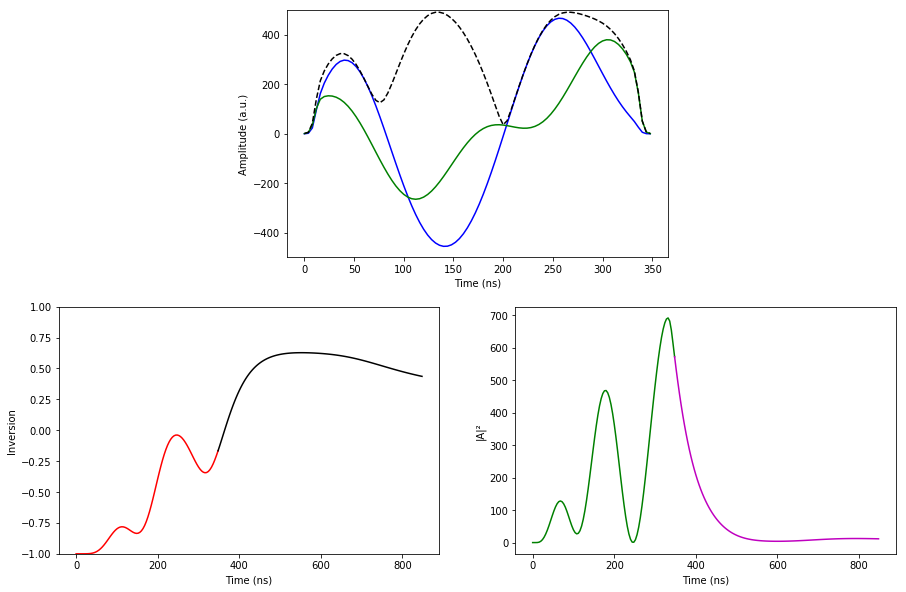

basinhopping step 0: f 0.26123
basinhopping step 1: f 0.235713 trial_f 0.235713 accepted 1  lowest_f 0.235713
found new global minimum on step 1 with function value 0.235713
basinhopping step 2: f 0.210991 trial_f 0.210991 accepted 1  lowest_f 0.210991
found new global minimum on step 2 with function value 0.210991
basinhopping step 3: f 0.188817 trial_f 0.188817 accepted 1  lowest_f 0.188817
found new global minimum on step 3 with function value 0.188817
basinhopping step 4: f 0.188772 trial_f 0.188772 accepted 1  lowest_f 0.188772
found new global minimum on step 4 with function value 0.188772
basinhopping step 5: f 0.188631 trial_f 0.188631 accepted 1  lowest_f 0.188631
found new global minimum on step 5 with function value 0.188631
basinhopping step 6: f 0.188382 trial_f 0.188382 accepted 1  lowest_f 0.188382
found new global minimum on step 6 with function value 0.188382
basinhopping step 7: f 0.188343 trial_f 0.188343 accepted 1  lowest_f 0.188343
found new global minimum on step

In [ ]:
gg = BasinHopping()
for i in range(100):
    res = gg.main()